In [43]:
import keras

import tensorflow.keras.backend as K

def custom_loss(y_true, y_pred):
    """
    Custom loss function for the specified task.

    Parameters:
    - y_true: Ground truth values, of shape (batch_size, 2, N).
    - y_pred: Predicted values, of shape (batch_size, 7,N).

    Returns:
    - loss: Scalar value representing the mean loss over the batch.
    """

    # Extract x and y values from y_true
    x_values = y_true[:,:,0]  # Shape: (batch_size, N)
    y_values = y_true[:,:,1]  # Shape: (batch_size, N)
    
    # print(x_values)
    # Apply the function to each element of y_pred based on the corresponding x_value
    # Result shape: (batch_size, N)
    # function_values = (
    #     y_pred[:, 0, :] * K.exp(-(x_values + y_pred[:, 1, :]) / y_pred[:, 2, :]) +
    #     y_pred[:, 3, :] * K.exp(-(x_values + y_pred[:, 4, :]) / y_pred[:, 5, :]) +
    #     y_pred[:, 6, :]
    # )
    function_values = (
        y_pred[:, :,0] * K.exp(-(x_values ) * y_pred[:, :,1]) +
        y_pred[:, :,2] * K.exp(-(x_values ) * y_pred[:, :,3]) +
        y_pred[:, :,4]
    )
    # Compute the difference between the function values and y_values
    # Result shape: (batch_size, N)
    diff = K.square(y_values -function_values) / K.maximum(y_values, y_values+0.001)
    #diff = diff /100
    # print(diff)
    # Take the square of the differences
    squared_diff = K.square(diff)

    # Take the mean over the batch
    # Result shape: (batch_size,)
    #loss = K.sum(K.abs(diff), axis=-1)
    loss = K.sum(squared_diff, axis=-1)
    return loss
 

def create_nn():
    global X_train, points
    # Input layer, the number of input nodes is governed by X_data.shape[1]
    # X_data.shape[1] is the number of columns in X_data
    inputs = keras.Input(shape=(X_train.shape[1],), name='input')
    
    # Dense layers 
    #layers_norm = keras.layers.BatchNormalization()(inputs)
    layers_dense = keras.layers.Dense(100, 'sigmoid')(inputs)
    layers_dense2 = keras.layers.Dense(100, 'sigmoid')(layers_dense)
    layers_dense3 = keras.layers.Dense(100, 'sigmoid')(layers_dense2)
    # Parameter layer
    # layers_norm = keras.layers.LayerNormalization()(layers_dense2)
    parameters = keras.layers.Dense(5)(layers_dense3)
    # Expand parameters to have same shape as y_true
    expanded_parameters = keras.layers.RepeatVector(points)(parameters)


    return keras.Model(inputs=inputs, outputs=expanded_parameters, name="current_function_prediction")

In [44]:
import model_function
import numpy as np
import matplotlib.pyplot as plt
points = 5
x = np.linspace(0,100, points)
A1 = 1
A2= 1
t1 = 5
t2= 3

j0 = 2
input_parameters = np.array((A1,t1,A2,t2,j0))
y_pred = np.tile(input_parameters, (1, points, 1))
#y_pred = np.reshape(y_pred,(1, 7, points))
#print(y_pred)

y = model_function.double_exponential_function(x, input_parameters)
print(f'y = {y}')
y_true = np.column_stack((x,y))
#y_true = np.reshape(y_true, (2,points))
y_true = np.expand_dims(y_true, axis=0)
print(y_true.shape)


print(K.eval(custom_loss(K.variable(y_true), K.variable(y_pred))).sum())



y = [4. 2. 2. 2. 2.]
(1, 5, 2)
0.0


In [45]:
import pandas as pd

df = pd.read_csv('E_4_20ms_20231103_14_55_46.csv', sep=', ')
df.head()

C:\Users\cierpind\AppData\Local\Temp\ipykernel_12656\3313802033.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('E_4_20ms_20231103_14_55_46.csv', sep=', ')


,Ch1(mA),Ch2(mA),Ch3(mA),Ch4(mA),Ch5(mA),Ch6(mA),Ch7(mA),Ch8(mA),Ch9(mA),Ch10(mA),...,Ch14(mA),Ch15(mA),Ch16(mA),Channel state,On time,Off time,Pulse number,Pattern,Time,Probeflag
0,0,0,0,0.000000,0,0,0,0,0,0,...,0,0,0,1000000000000,20,10,1,1/160,0.022460,False
1,0,0,0,0.000000,0,0,0,0,0,0,...,0,0,0,1000000000000,20,10,2,1/160,0.053628,False
2,0,0,0,0.004888,0,0,0,0,0,0,...,0,0,0,1000000000000,20,10,3,1/160,0.088193,False
3,0,0,0,0.004888,0,0,0,0,0,0,...,0,0,0,1000000000000,20,10,4,1/160,0.119002,False
4,0,0,0,0.004888,0,0,0,0,0,0,...,0,0,0,1000000000000,20,10,5,1/160,0.145032,False


In [46]:
df = df[ ['Pattern','Time','Ch4(mA)','On time', 'Off time']]
df = df.rename(columns={'Ch4(mA)': 'Current'})
df = df.drop(df.index[:400*10])
df.head()

,Pattern,Time,Current,On time,Off time
4000,11/160,292.692618,0.7625,20,30
4001,11/160,292.741174,0.7869,20,30
4002,11/160,292.792088,0.8065,20,30
4003,11/160,292.843058,0.8260,20,30
4004,11/160,292.895197,0.8407,20,30


Text(0.5, 1.0, 'Data to be modeled')

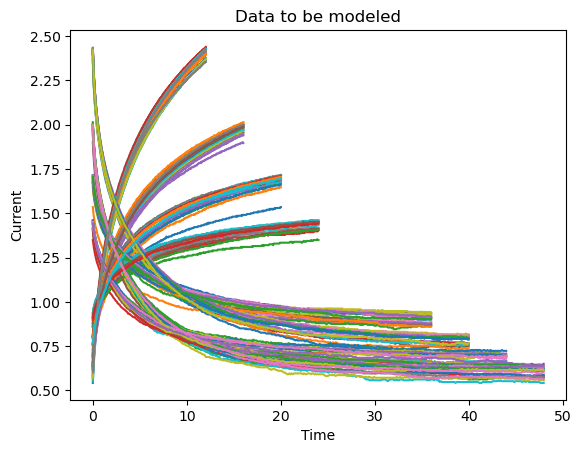

In [47]:
grouped = df.groupby('Pattern')
list_of_dfs = [group for _, group in grouped]
for data in list_of_dfs:    
    x_time = data['Time']-np.min(data['Time'])
    y_current = data['Current']
    points = len(y_current)    
    #(data.loc[0,'Off time'])
    if len(y_current) != 400:
        print(points)
        continue
    assert x_time.shape == y_current.shape
    assert points == 400
    plt.plot(x_time, y_current, '-')
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Data to be modeled')

In [48]:
#initialize array of expected shape
X_data = np.zeros((len(list_of_dfs),4))
#initialize array of expected shape
y_data = np.zeros((len(list_of_dfs), points, 2))
print(f"X shape:{X_data.shape}")
print(f"y shape:{y_data.shape}")
for i in range(len(list_of_dfs)):
    data = list_of_dfs[i]
    x_time = data['Time']-np.min(data['Time'])
    y_current = data['Current']
    
    if len(y_current) != 400:
         print(points)
         continue
    label = np.column_stack((x_time,y_current))  
    y_data[i,:,:]= label
    features =  np.array([4, np.min(y_current.values), data['On time'].iloc[0], data['Off time'].iloc[0]])
    X_data[i,:] = features


X shape:(150, 4)
y shape:(150, 400, 2)


In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, train_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, train_size=0.5)

In [50]:
model = create_nn()
model.summary()

Model: "current_function_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_12 (Dense)            (None, 100)               500       
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 100)               10100     
                                                                 
 dense_15 (Dense)            (None, 5)                 505       
                                                                 
 repeat_vector_3 (RepeatVec  (None, 400, 5)            0         
 tor)                                                            
                                       

In [51]:
def compile_model(model):
    sgd = keras.optimizers.RMSprop(clipnorm=5)
    model.compile(optimizer=sgd, #'adam'
                  loss=custom_loss)
    
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss",baseline = 1, patience=200,restore_best_weights=True)

compile_model(model)

import seaborn as sns
def plot_history(history, metrics):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.ylim(0,100)
    plt.xlabel("epochs")
    plt.ylabel("metric")



In [52]:
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=200,
                    validation_data = (X_val,y_val),
                    callbacks=[earlystopper],
                    verbose=2)

Epoch 1/200
11/11 - 1s - loss: 52.6723 - val_loss: 1067012065976529800596029440.0000 - 527ms/epoch - 48ms/step
Epoch 2/200
11/11 - 0s - loss: 3514324040935217841997611008.0000 - val_loss: 1067012065976529800596029440.0000 - 23ms/epoch - 2ms/step
Epoch 3/200
11/11 - 0s - loss: 3514324040935217841997611008.0000 - val_loss: 1067012065976529800596029440.0000 - 28ms/epoch - 3ms/step
Epoch 4/200
11/11 - 0s - loss: 3514324040935217841997611008.0000 - val_loss: 1067012065976529800596029440.0000 - 25ms/epoch - 2ms/step
Epoch 5/200
11/11 - 0s - loss: 3514323745787312662644785152.0000 - val_loss: 1067012065976529800596029440.0000 - 23ms/epoch - 2ms/step
Epoch 6/200
11/11 - 0s - loss: 3514324040935217841997611008.0000 - val_loss: 1067012065976529800596029440.0000 - 26ms/epoch - 2ms/step
Epoch 7/200
11/11 - 0s - loss: 3514324040935217841997611008.0000 - val_loss: 1067012065976529800596029440.0000 - 28ms/epoch - 3ms/step
Epoch 8/200
11/11 - 0s - loss: 3514323745787312662644785152.0000 - val_loss: 10

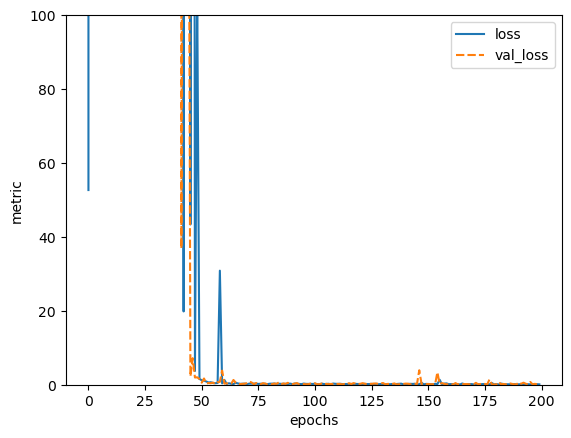

In [53]:
# call the plot_history function with the apropriate object and string
plot_history(history, ['loss', 'val_loss'])

In [54]:
# make prediction on test data
y_train_prediction = model.predict(X_train)



4/4 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Relative error of training data prediction')

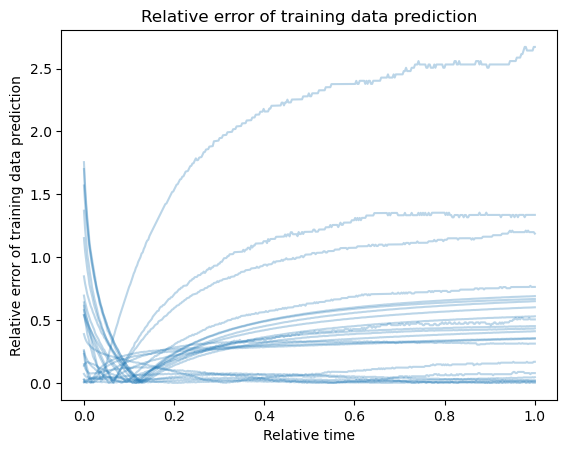

In [55]:
y_train_prediction = model.predict(X_train)

# from matplotlib.pyplot import cm
# color = iter(cm.rainbow(np.linspace(0, 1, X_test.shape[0]-5)))
for test_entry_index in range(X_test.shape[0]):
    # c = next(color)
    y_true = y_test[test_entry_index,:,:]
    param_predicted = y_train_prediction[test_entry_index,0 ,: ]
    plt.plot(y_true[:,0]/np.max(y_true), np.abs(y_true[:,1]- model_function.double_exponential_function(y_true[:,0], param_predicted))/y_true[:,1], '-', color = 'C0', alpha = 0.3, )
    # plt.plot(y_true[:,0], y_true[:,1], '-', color = 'C0', alpha = 0.7)
    # plt.plot(y_true[:,0], model_function.double_exponential_function(y_true[:,0], param_predicted), '-', color = 'C1')
#plt.legend()
plt.xlabel('Relative time')
plt.ylabel('Relative error of training data prediction')
plt.title('Relative error of training data prediction')

1/1 [==============================] - 0s 12ms/step


Text(0.5, 1.0, 'Relative error of test data prediction')

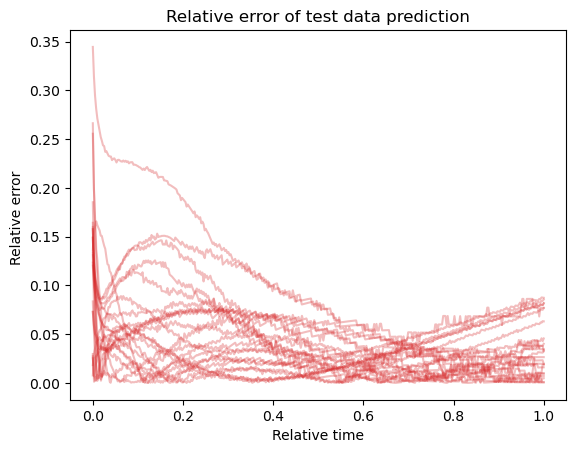

In [56]:
y_test_prediction = model.predict(X_test)

# from matplotlib.pyplot import cm
# color = iter(cm.rainbow(np.linspace(0, 1, X_test.shape[0]-5)))
for test_entry_index in range(X_test.shape[0]):
    # c = next(color)
    y_true = y_test[test_entry_index,:,:]
    param_predicted = y_test_prediction[test_entry_index,0 ,: ]
    plt.plot(y_true[:,0]/np.max(y_true), np.abs(y_true[:,1]- model_function.double_exponential_function(y_true[:,0], param_predicted))/y_true[:,1], '-', color = 'C3', alpha = 0.3, )
    # plt.plot(y_true[:,0], y_true[:,1], '-', color = 'C0', alpha = 0.7)
    # plt.plot(y_true[:,0], model_function.double_exponential_function(y_true[:,0], param_predicted), '-', color = 'C1')
#plt.legend()
plt.xlabel('Relative time')
plt.ylabel('Relative error ')
plt.title('Relative error of test data prediction')